In [1]:
import os
import pandas as pd
import re
import nltk
import contractions
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load the CSV data into a DataFrame
csv_file = "combined_data.csv"
df = pd.read_csv(csv_file)

In [2]:
df.dropna(subset=['body'], inplace=True)
df.drop_duplicates(subset='body', inplace=True)
df.shape[0]

3508664

In [3]:
flagged_df = df[df['label'] != 'nonflagged']
non_flagged_df = df[df['label'] == 'nonflagged']

num_samples_per_class = 100000
# Randomly sample from each class to create a balanced dataset
flagged_sampled = flagged_df.sample(n=num_samples_per_class, random_state=50)
non_flagged_sampled = non_flagged_df.sample(n=num_samples_per_class, random_state=50)

# # Concatenate the sampled DataFrames to create the balanced dataset
df = pd.concat([flagged_sampled, non_flagged_sampled], ignore_index=True)

In [4]:
'''
Added 2 more pre processing steps.
'''

import pandas as pd
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
import contractions
def preprocess_text(text):
    if pd.isna(text) or not text.strip():
        return ''  # Replace empty strings or NaN with an empty string
    
    text = text.lower()
    text = re.sub(r'[^\w\s,]', '', text)
    text = re.sub(r'[0-9]', '', text)
    text = ''.join(char for char in text if ord(char) < 128)
    
    # Normalize contractions
    text = contractions.fix(text)
    
    # Tokenize the text using NLTK's word_tokenize
    words = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))  # Change 'english' to your language if needed
    words = [word for word in words if word not in stop_words]
    
    # Perform stemming and lemmatization
    '''
    Stemmer and lemmatizer are going to convert a word to it's root form.
    '''
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    words = [stemmer.stem(lemmatizer.lemmatize(word)) for word in words]
    
    return ' '.join(words)

df['body'] = df['body'].apply(preprocess_text)
# Check the number of rows in the DataFrame after preprocessing
num_rows = df.shape[0]
print(f'Number of rows after preprocessing: {num_rows}')

Number of rows after preprocessing: 200000


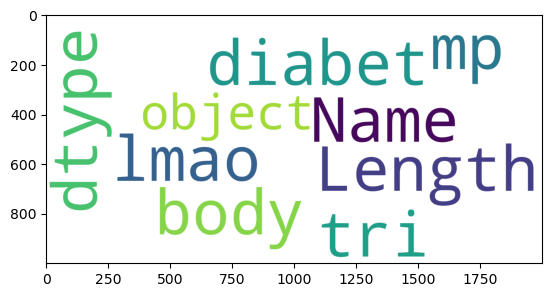

In [54]:
'''
Added Word Cloud Visualization for the over all input.
'''
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',stopwords=stopwords,max_words = 5000,max_font_size = 50, scale = 5).generate(str(df['body']))
plt.imshow(wordcloud)

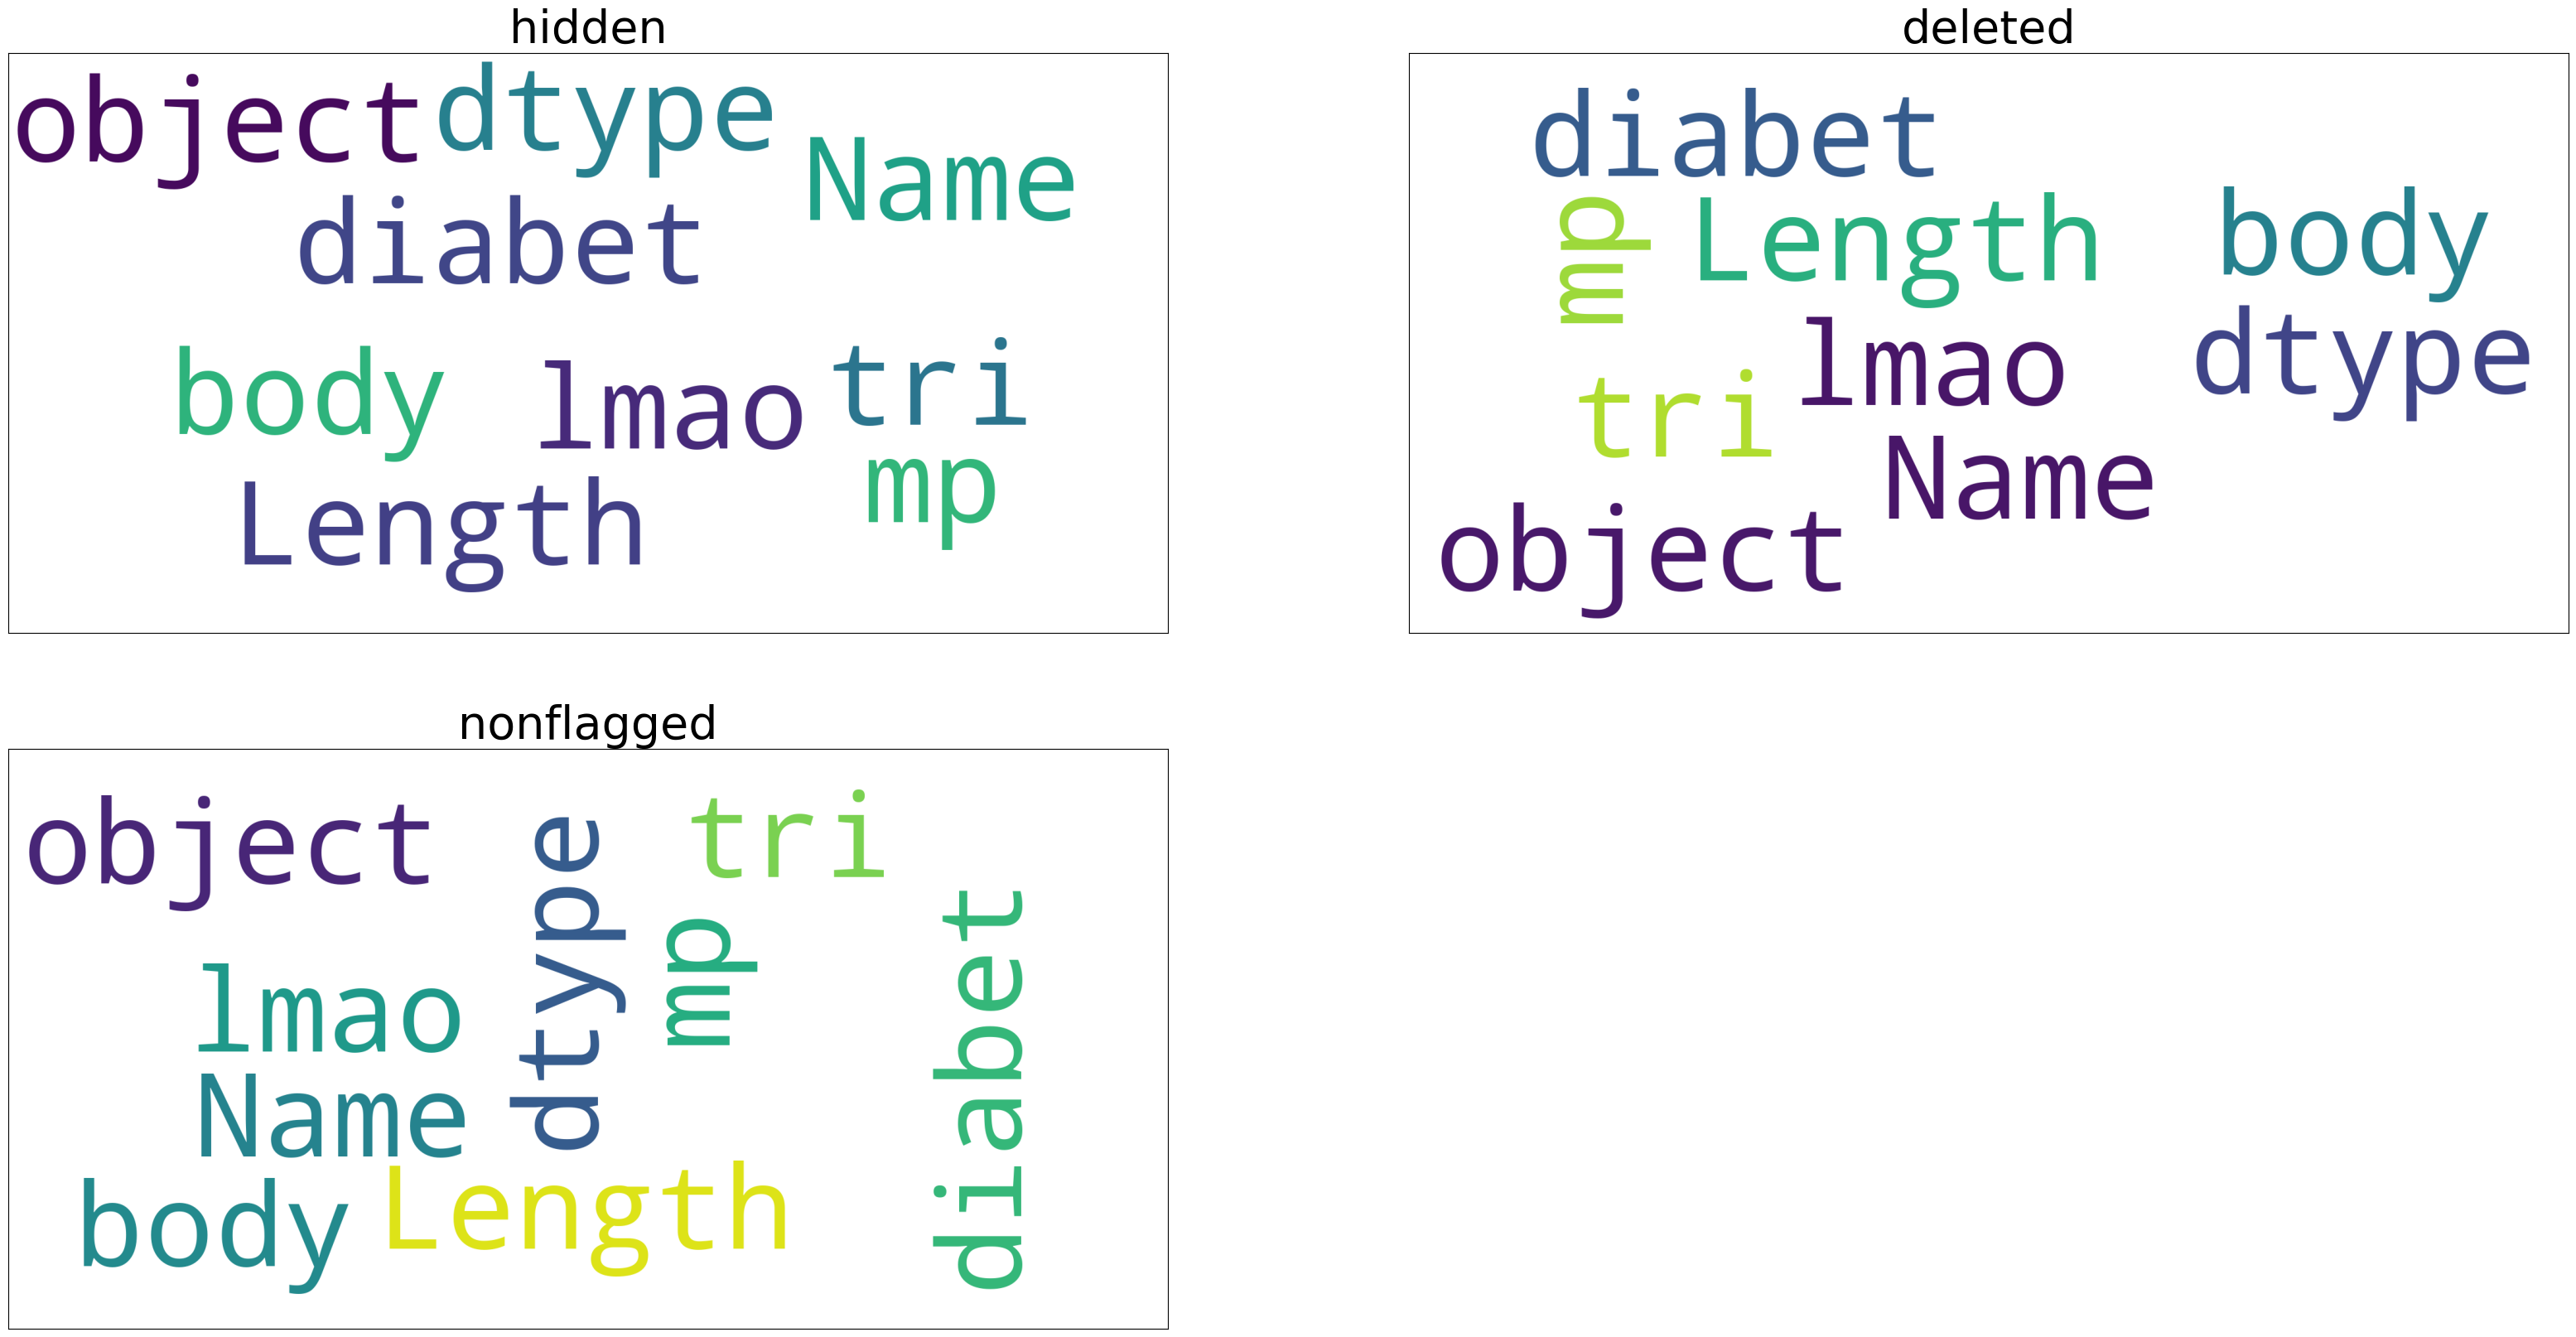

In [55]:
'''
Added Word Cloud Visualization for each label.
'''
plt.figure(figsize=(40,20))
for index, sent in enumerate(df['label'].unique()):
    plt.subplot(2,2,index+1)
    data = df[df['label'] == sent]['body']
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color='white',stopwords=stopwords,max_words = 50,max_font_size = 40, scale = 5).generate(str(df['body']))
    plt.imshow(wordcloud)
    plt.xticks([])
    plt.yticks([])
    plt.title(sent,fontsize=40)

In [5]:
# Label Encoding
df['label'] = df['label'].map({'deleted': 1, 'hidden': 1, 'nonflagged': 0})

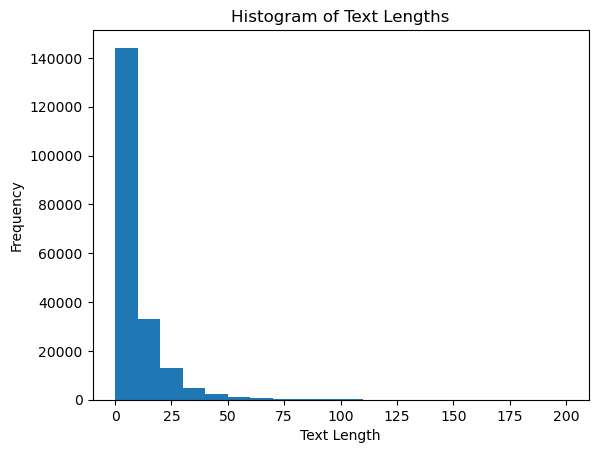

In [57]:
import matplotlib.pyplot as plt

# Calculate the length of each body and create a histogram
df['text_length'] = df['body'].apply(len)
plt.hist(df['text_length'], bins=20)  # Adjust the number of bins as needed
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths')
plt.show()

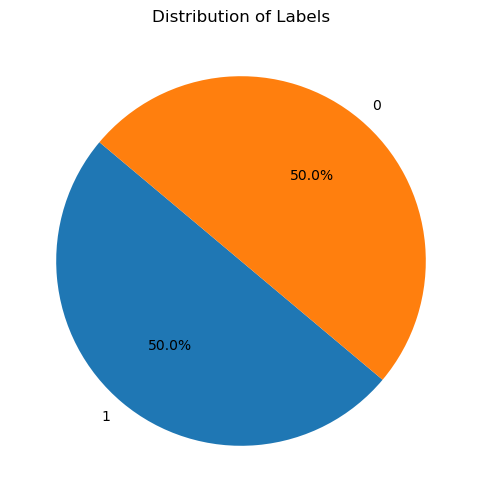

In [58]:
import seaborn as sns

label_counts = df['label'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))  # Set the figure size
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')

plt.show()

In [59]:
final_data = df
import pandas as pd

final_data.to_csv('final_data.csv', index=False)

In [84]:
# Feature Extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = tfidf_vectorizer.fit_transform(df['body'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

In [125]:
'''
Added Feature Extraction using Word2Vec

'''
import numpy as np

# Feature Extraction using Word2Vec
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['body'], vector_size=100, window=10, min_count=5, workers=5)

# Function to calculate the average word vector for a document
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# Create word vectors for each document
X_word2vec = [average_word_vectors(words, word2vec_model, word2vec_model.wv.index_to_key, 100) for words in df['body']]

# Convert to numpy array
X_word2vec = np.array(X_word2vec)

# Label Encoding for the target variable
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, df['label'], test_size=0.2, random_state=42)

In [109]:
''' 
Added Feature Extraction using Sentiment Lexicon
'''

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['body'], vector_size=100, window=10, min_count=5, workers=5)

# Function to calculate the average word vector for a document
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# Create word vectors for each document
X_word2vec = [average_word_vectors(words, word2vec_model, word2vec_model.wv.index_to_key, 100) for words in df['body']]

# Convert to numpy array
X_word2vec = np.array(X_word2vec)

# Add sentiment lexicon features using vaderSentiment
analyzer = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each document
sentiment_scores = df['body'].apply(lambda x: analyzer.polarity_scores(x))

# Extract compound sentiment scores
compound_scores = sentiment_scores.apply(lambda x: x['compound']).values.reshape(-1, 1)

# Concatenate sentiment lexicon features with Word2Vec features
X_combined = np.concatenate((X_word2vec, compound_scores), axis=1)

# Label Encoding for the target variable
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['label'], test_size=0.2, random_state=42)

In [13]:
''' 
Added Feature Extraction using fastText
'''
import numpy as np
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Train fastText model
fasttext_model = FastText(sentences=df['body'], vector_size=400, window=10, min_count=5, workers=5)

# Function to calculate the average word vector for a document using fastText
def average_word_vectors_fasttext(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        nwords = nwords + 1.
        feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# Create word vectors for each document using fastText
X_fasttext = [average_word_vectors_fasttext(words, fasttext_model, 400) for words in df['body']]

# Convert to numpy array
X_fasttext = np.array(X_fasttext)

# Label Encoding for the target variable
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_fasttext, df['label'], test_size=0.2, random_state=42)

In [7]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler with with_mean=False for sparse matrices
scaler = StandardScaler(with_mean=False)

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [123]:
'''
Added Decision Tree
6000 = min_samples_split
12 = max_features
entropy gave better accuracy
max_depth = 8
'''

from sklearn.tree import DecisionTreeClassifier

# Model Training (Decision Tree)
tree_model = DecisionTreeClassifier(criterion='entropy', min_samples_split = 6000, max_depth = 8, max_features = 12, random_state=42)
tree_model.fit(X_train, y_train)

# Model Evaluation
y_pred_tree = tree_model.predict(X_test)

# Calculate accuracy
accuracy_tree = accuracy_score(y_test, y_pred_tree)

# Calculate precision, recall, and F1-score for the decision tree
precision_tree = precision_score(y_test, y_pred_tree)
recall_tree = recall_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)

# Calculate classification report for the decision tree
class_report_tree = classification_report(y_test, y_pred_tree)

# Calculate confusion matrix for the decision tree
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)

print('Decision Tree Model Evaluation:')
print(f'Accuracy: {accuracy_tree}')
print(f'Precision: {precision_tree}')
print(f'Recall: {recall_tree}')
print(f'F1 Score: {f1_tree}')
print('Classification Report:')
print(class_report_tree)
print('Confusion Matrix:')
print(conf_matrix_tree)

Decision Tree Model Evaluation:
Accuracy: 0.650175
Precision: 0.6772211720226843
Recall: 0.5734006902415846
F1 Score: 0.6210015980065545
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.73      0.68     20007
           1       0.68      0.57      0.62     19993

    accuracy                           0.65     40000
   macro avg       0.65      0.65      0.65     40000
weighted avg       0.65      0.65      0.65     40000

Confusion Matrix:
[[14543  5464]
 [ 8529 11464]]


In [127]:
'''
Added Random Forest
Gini Impurity was seen as the better criterion.
A high value of min_samples_split gave better results. Around 5300.
max_features = 32
'''

from sklearn.ensemble import RandomForestClassifier

# Model Training (Random Forest)
forest_model = RandomForestClassifier(n_estimators=20, criterion='gini', max_depth = 8, min_samples_split=5300, max_features = 32, random_state=42)
forest_model.fit(X_train, y_train)

# Model Evaluation
y_pred_forest = forest_model.predict(X_test)

# Calculate accuracy
accuracy_forest = accuracy_score(y_test, y_pred_forest)

# Calculate precision, recall, and F1-score for the Random Forest
precision_forest = precision_score(y_test, y_pred_forest)
recall_forest = recall_score(y_test, y_pred_forest)
f1_forest = f1_score(y_test, y_pred_forest)

# Calculate classification report for the Random Forest
class_report_forest = classification_report(y_test, y_pred_forest)

# Calculate confusion matrix for the Random Forest
conf_matrix_forest = confusion_matrix(y_test, y_pred_forest)

print('Random Forest Model Evaluation:')
print(f'Accuracy: {accuracy_forest}')
print(f'Precision: {precision_forest}')
print(f'Recall: {recall_forest}')
print(f'F1 Score: {f1_forest}')
print('Classification Report:')
print(class_report_forest)
print('Confusion Matrix:')
print(conf_matrix_forest)

Random Forest Model Evaluation:
Accuracy: 0.65065
Precision: 0.6762311881478011
Recall: 0.5776021607562647
F1 Score: 0.6230374966280011
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.72      0.67     20007
           1       0.68      0.58      0.62     19993

    accuracy                           0.65     40000
   macro avg       0.65      0.65      0.65     40000
weighted avg       0.65      0.65      0.65     40000

Confusion Matrix:
[[14478  5529]
 [ 8445 11548]]
